In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import pickle as pkl

from sklearn.preprocessing import maxabs_scale

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from diffxpy.testing.det import DifferentialExpressionTestWald
import diffxpy.api as de

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/data_exploration/')
import helper_diffxpy as hde
import importlib
importlib.reload(hde)
import helper_diffxpy as hde

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

In [5]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_save=path_data+'embryo_DE/'
path_save_de_delta=path_save+'diffxpy_deltaMature/'
path_dotplots=path_save+'embryo_maturation_plots/'

In [6]:
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [7]:
adata_rawnorm=sc.read(path_data+'data_rawnorm_integrated_annotated.h5ad')

In [8]:
# Add ct info
adata_full=sc.read(path_data+'data_integrated_analysed.h5ad',backed='r')
adata_rawnorm.obs[['cell_type_integrated_v1','pre_cell_type_original']]=\
    adata_full.obs[['cell_type_integrated_v1','pre_cell_type_original']].copy()
del adata_full

In [9]:
# Use correct layer
adata_rawnorm.X=adata_rawnorm.layers['X_sf_integrated']

### Make cell groups

Subset to embryo and non-embryo endo cells. For non-embryo endo cells use cells that are annotated as endo and do not come from embryo study. For embryo-endo use embryo study ct anno and subset to cells mapping to embryo_endocrine cluster in atlas anno (as at older ages some alpha/belta already map to postnatal endo clusters). Thrid group of cells is embryo cells mapping to postnatal endo cluster (regardless of original ct annotation from the embryo-dataset study). Did not use epsilon as little in adult. Did not use gamma as not yet really present in embryo.

In [10]:
# Embryo cts
adata_rawnorm.obs.query('study=="embryo"')['pre_cell_type_original'].\
    cat.remove_unused_categories().value_counts()

Mat. Acinar        6972
Ductal             4262
Tip                3796
Prlf. Acinar       3289
Ngn3 low EP        2582
Prlf. Ductal       2298
Prlf. Tip          2193
Ngn3 High late     1726
NA                 1641
Fev+ Beta          1359
Beta               1232
Prlf. Trunk        1188
Multipotent        1187
secondary Alpha    1159
Ngn3 High early     767
Trunk               615
Fev+ Alpha          345
primary Alpha       263
Epsilon             230
Fev+ Pyy            132
Fev+ Epsilon        112
Fev+ Delta          110
Delta               103
Name: pre_cell_type_original, dtype: int64

Compute cell groups and report their sizes

In [11]:
# Add ct groups
adata_rawnorm.obs['ct_de']=np.nan
endo_cts=['alpha','beta','gamma','delta']
endo_postnatal=adata_rawnorm.obs.query(
    'study!="embryo" and cell_type_integrated_v1 in @endo_cts').index
adata_rawnorm.obs.loc[endo_postnatal,'ct_de']=adata_rawnorm.obs.loc[
    endo_postnatal,'cell_type_integrated_v1'].apply(lambda x: x+'_postnatal')
endo_embryo_mature=adata_rawnorm.obs.query(
    'study=="embryo" and cell_type_integrated_v1 in @endo_cts').index
adata_rawnorm.obs.loc[endo_embryo_mature,'ct_de']=adata_rawnorm.obs.loc[
    endo_embryo_mature,'cell_type_integrated_v1'].apply(lambda x: x+'_embryo_mature')
endo_cts_embryo=['primary Alpha','secondary Alpha','Beta','Delta','Gamma']
endo_embryo=adata_rawnorm.obs.query(
    'study=="embryo" and cell_type_integrated_v1=="embryo endocrine" and '+
    'pre_cell_type_original in @endo_cts_embryo').index
adata_rawnorm.obs.loc[endo_embryo,'ct_de']=adata_rawnorm.obs.loc[
    endo_embryo,'pre_cell_type_original'].apply(
    lambda x: x.lower().replace('primary ','').replace('secondary ','')+'_embryo')
adata_rawnorm.obs['ct_de'].value_counts()

beta_postnatal         102109
alpha_postnatal         40903
delta_postnatal         24663
gamma_postnatal          6993
alpha_embryo             1378
beta_embryo              1220
delta_embryo_mature       112
beta_embryo_mature         34
alpha_embryo_mature        32
delta_embryo               17
gamma_embryo_mature         6
Name: ct_de, dtype: int64

Make ct names pretty for plotting

In [13]:
# Make ct names pretty
adata_rawnorm.obs['ct_de_parsed']=adata_rawnorm.obs['ct_de'].str.replace('_',' ')
adata_rawnorm.obs['ct_de_parsed']=adata_rawnorm.obs['ct_de_parsed'].\
    str.replace('mature','P-like').str.replace('postnatal','P').str.replace('embryo','E')
print(adata_rawnorm.obs['ct_de_parsed'].unique())

['beta P' 'delta P' nan 'alpha P' 'gamma P' 'alpha E' 'delta E P-like'
 'beta E' 'beta E P-like' 'delta E' 'alpha E P-like' 'gamma E P-like']


### Proportions of embryonic groups across embryo ages and cts
In embryonic dataset compare across endo cell types and samples (differing in age) how many cells (relatively to total sample size) map to embryo and embryo postnatal-like groups.

In [108]:
# Compute what ratio of embryonic sample represent different cell groups 
ratios=[]
for ct in ['alpha','beta','delta']: # gamma not in embryo and epsilon not in postnatal
    for subtype in ['E','E P-like']:
        ct_name=ct+' '+subtype
        for age,data in adata_rawnorm.obs.query('study=="embryo"'
                                               ).groupby('age',observed=True):
            ratio=data.query('ct_de_parsed==@ct_name').shape[0]/data.shape[0]
            ratios.append({'age':age,'cell type':ct,'subtype':subtype,
                           'ratio of sample':ratio})
ratios=pd.DataFrame(ratios)
ratios.age=pd.Categorical(ratios.age,
    [str(round(age,1))+' E' for age in 
     sorted([float(age.split()[0]) for age in ratios.age.unique()])])

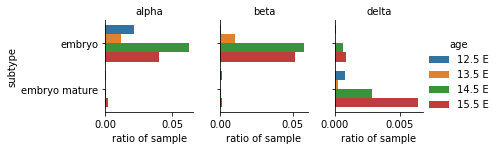

In [109]:
# Plot
g=sb.catplot(y="subtype", x="ratio of sample",
                hue="age", col="cell type",
                data=ratios, kind="bar",
                height=2, aspect=1,sharex=False);
g.set(facecolor = (0,0,0,0))
for ax in g.axes[0]:
    ax.set_title(ax.get_title().split('= ')[1],fontsize=10)
plt.savefig(path_fig+'barplot_atlas_embryoEndoRatio_matureVSembryo.png',dpi=300,bbox_inches='tight')    

### Known embryonic development and delta function genes
Analyse known development and function genes to see why embryonic delta cells may be more similar to postnatal cells.

Fev+ markers across endo groups

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'ct_de' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categorie

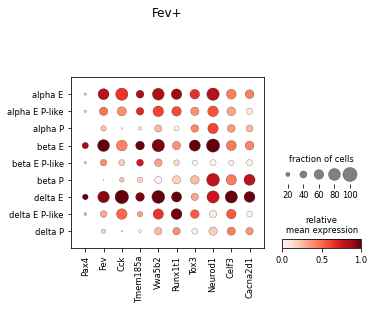

In [14]:
genes=['Fev','Tox3','Tmem185a','Pax4','Cck','Neurod1','Vwa5b2','Celf3',
                        'Runx1t1','Cacna2d1']
# Sort based on expression "center" across maturation subtypes, averaged across cts
means=[]
for ct in ['alpha','beta','delta']:
    # Order genes for plotting based on expression in marking ct across maturity clusters
    data=adata_rawnorm[adata_rawnorm.obs.ct_de.str.contains(ct).fillna(False),
                   adata_rawnorm.var.query('gene_symbol in @genes').index].to_df()
    data['ct_de']=adata_rawnorm[adata_rawnorm.obs.ct_de.str.contains(ct).fillna(False),
                                :].obs.ct_de
    data=data.groupby('ct_de').mean()
    # Sorting to enable plotting from embryonic to postnatal markers
    ct_pos={'embryo':1,'embryo_mature':2,'postnatal':3}
    data.index=[ct_pos[i.replace(ct+'_','')] for i in data.index]
    means.append(
        # If mean expression per subtype (y) was empirical distn over sorted subtypes (x), 
        # where would be mean (x)
        data.apply(
          lambda x: np.array([y for n,e in x.iteritems() 
                        for y in [n]*int(e/x.sum()*100)]).mean()).rename(ct))
means=pd.DataFrame(means)
genes=means.mean().sort_values().index
genes=list(adata_rawnorm.var.loc[genes,'gene_symbol'].values)

sc.pl.dotplot(adata_rawnorm[
        ~adata_rawnorm.obs.ct_de.isna().values & 
        ~adata_rawnorm.obs.ct_de.str.contains('gamma').fillna(False).values
        ,:], var_names=genes,
                         gene_symbols='gene_symbol',use_raw=False,
              groupby='ct_de_parsed',
              standard_scale='var',title='Fev+',
              size_title='fraction of cells',
              colorbar_title='relative\nmean expression',
              show=False)
plt.savefig(path_fig+'dotplot_atlas_embryoMaturation_markers_Fev.png',dpi=300,
                bbox_inches='tight')

Fev+ (subset of genes) and delta functional markers across delta groups

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'ct_de' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categorie

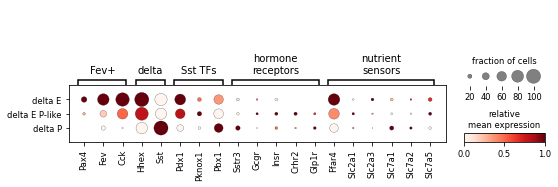

In [15]:
genes={
       'Fev+':['Pax4','Fev','Cck'],
       'delta':['Hhex','Sst'],
       'Sst TFs':['Pdx1','Pknox1', 'Pbx1'],
       'hormone\nreceptors':['Sstr3','Gcgr','Insr','Crhr2','Glp1r'],
       'nutrient\nsensors':['Ffar4','Slc2a1','Slc2a3','Slc7a1','Slc7a2','Slc7a5'],
      }
sc.pl.dotplot(adata_rawnorm[
        adata_rawnorm.obs.ct_de.str.startswith('delta').fillna(False)
        ,:], var_names=genes,
                         gene_symbols='gene_symbol',use_raw=False,
              groupby='ct_de_parsed',
              standard_scale='var',
                size_title='fraction of cells',
              colorbar_title='relative\nmean expression',
              show=False,var_group_rotation=0)
plt.savefig(path_fig+'dotplot_atlas_embryoMaturationDelta_markers_FevDelta.png',dpi=300,
                bbox_inches='tight')